## Performing Sentiment analysis of movie reviews using multilayer RNNs.

Sentiment analysis is concerned with analyzing the expressed opinion of a sentence or a text document.

Movie dataset contains two columns, namely 'review' and 'sentiment', where review contains the text of movie reviews and 'sentiment' contains the '0' or '1' labels. The text component of these movie reviews are sequence of words; therefore, we want to build an RNN model to process the words in each sequence, and at the end, classify the entire sequence to 0 or 1 classes.

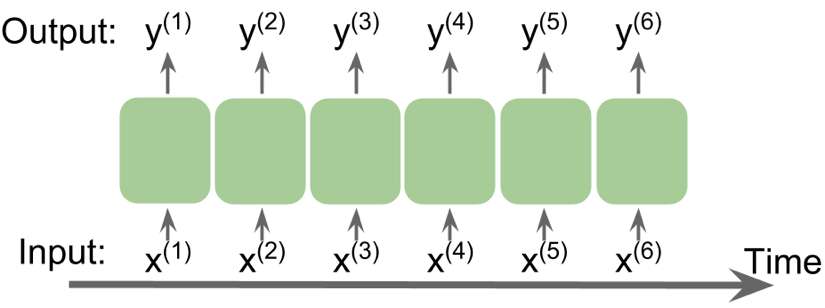

In [13]:
from IPython.display import Image
# Representing Sequences
Image(filename='images/Unknown-5.png', width=600)

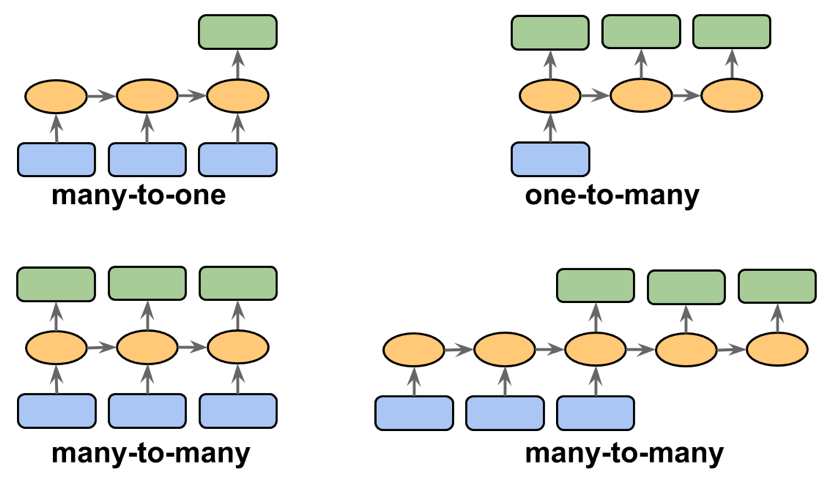

In [14]:
# Understanding the different categories of sequence modeling
Image(filename='images/Unknown-6.png', width=600)

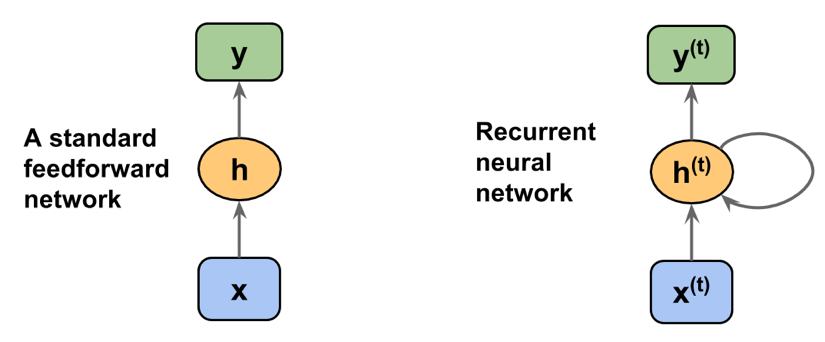

In [15]:
# Recurrent neural networks for modeling sequences
# Understanding the structure and flow of a recurrent neural network
Image(filename='images/Unknown-7.png', width=600)

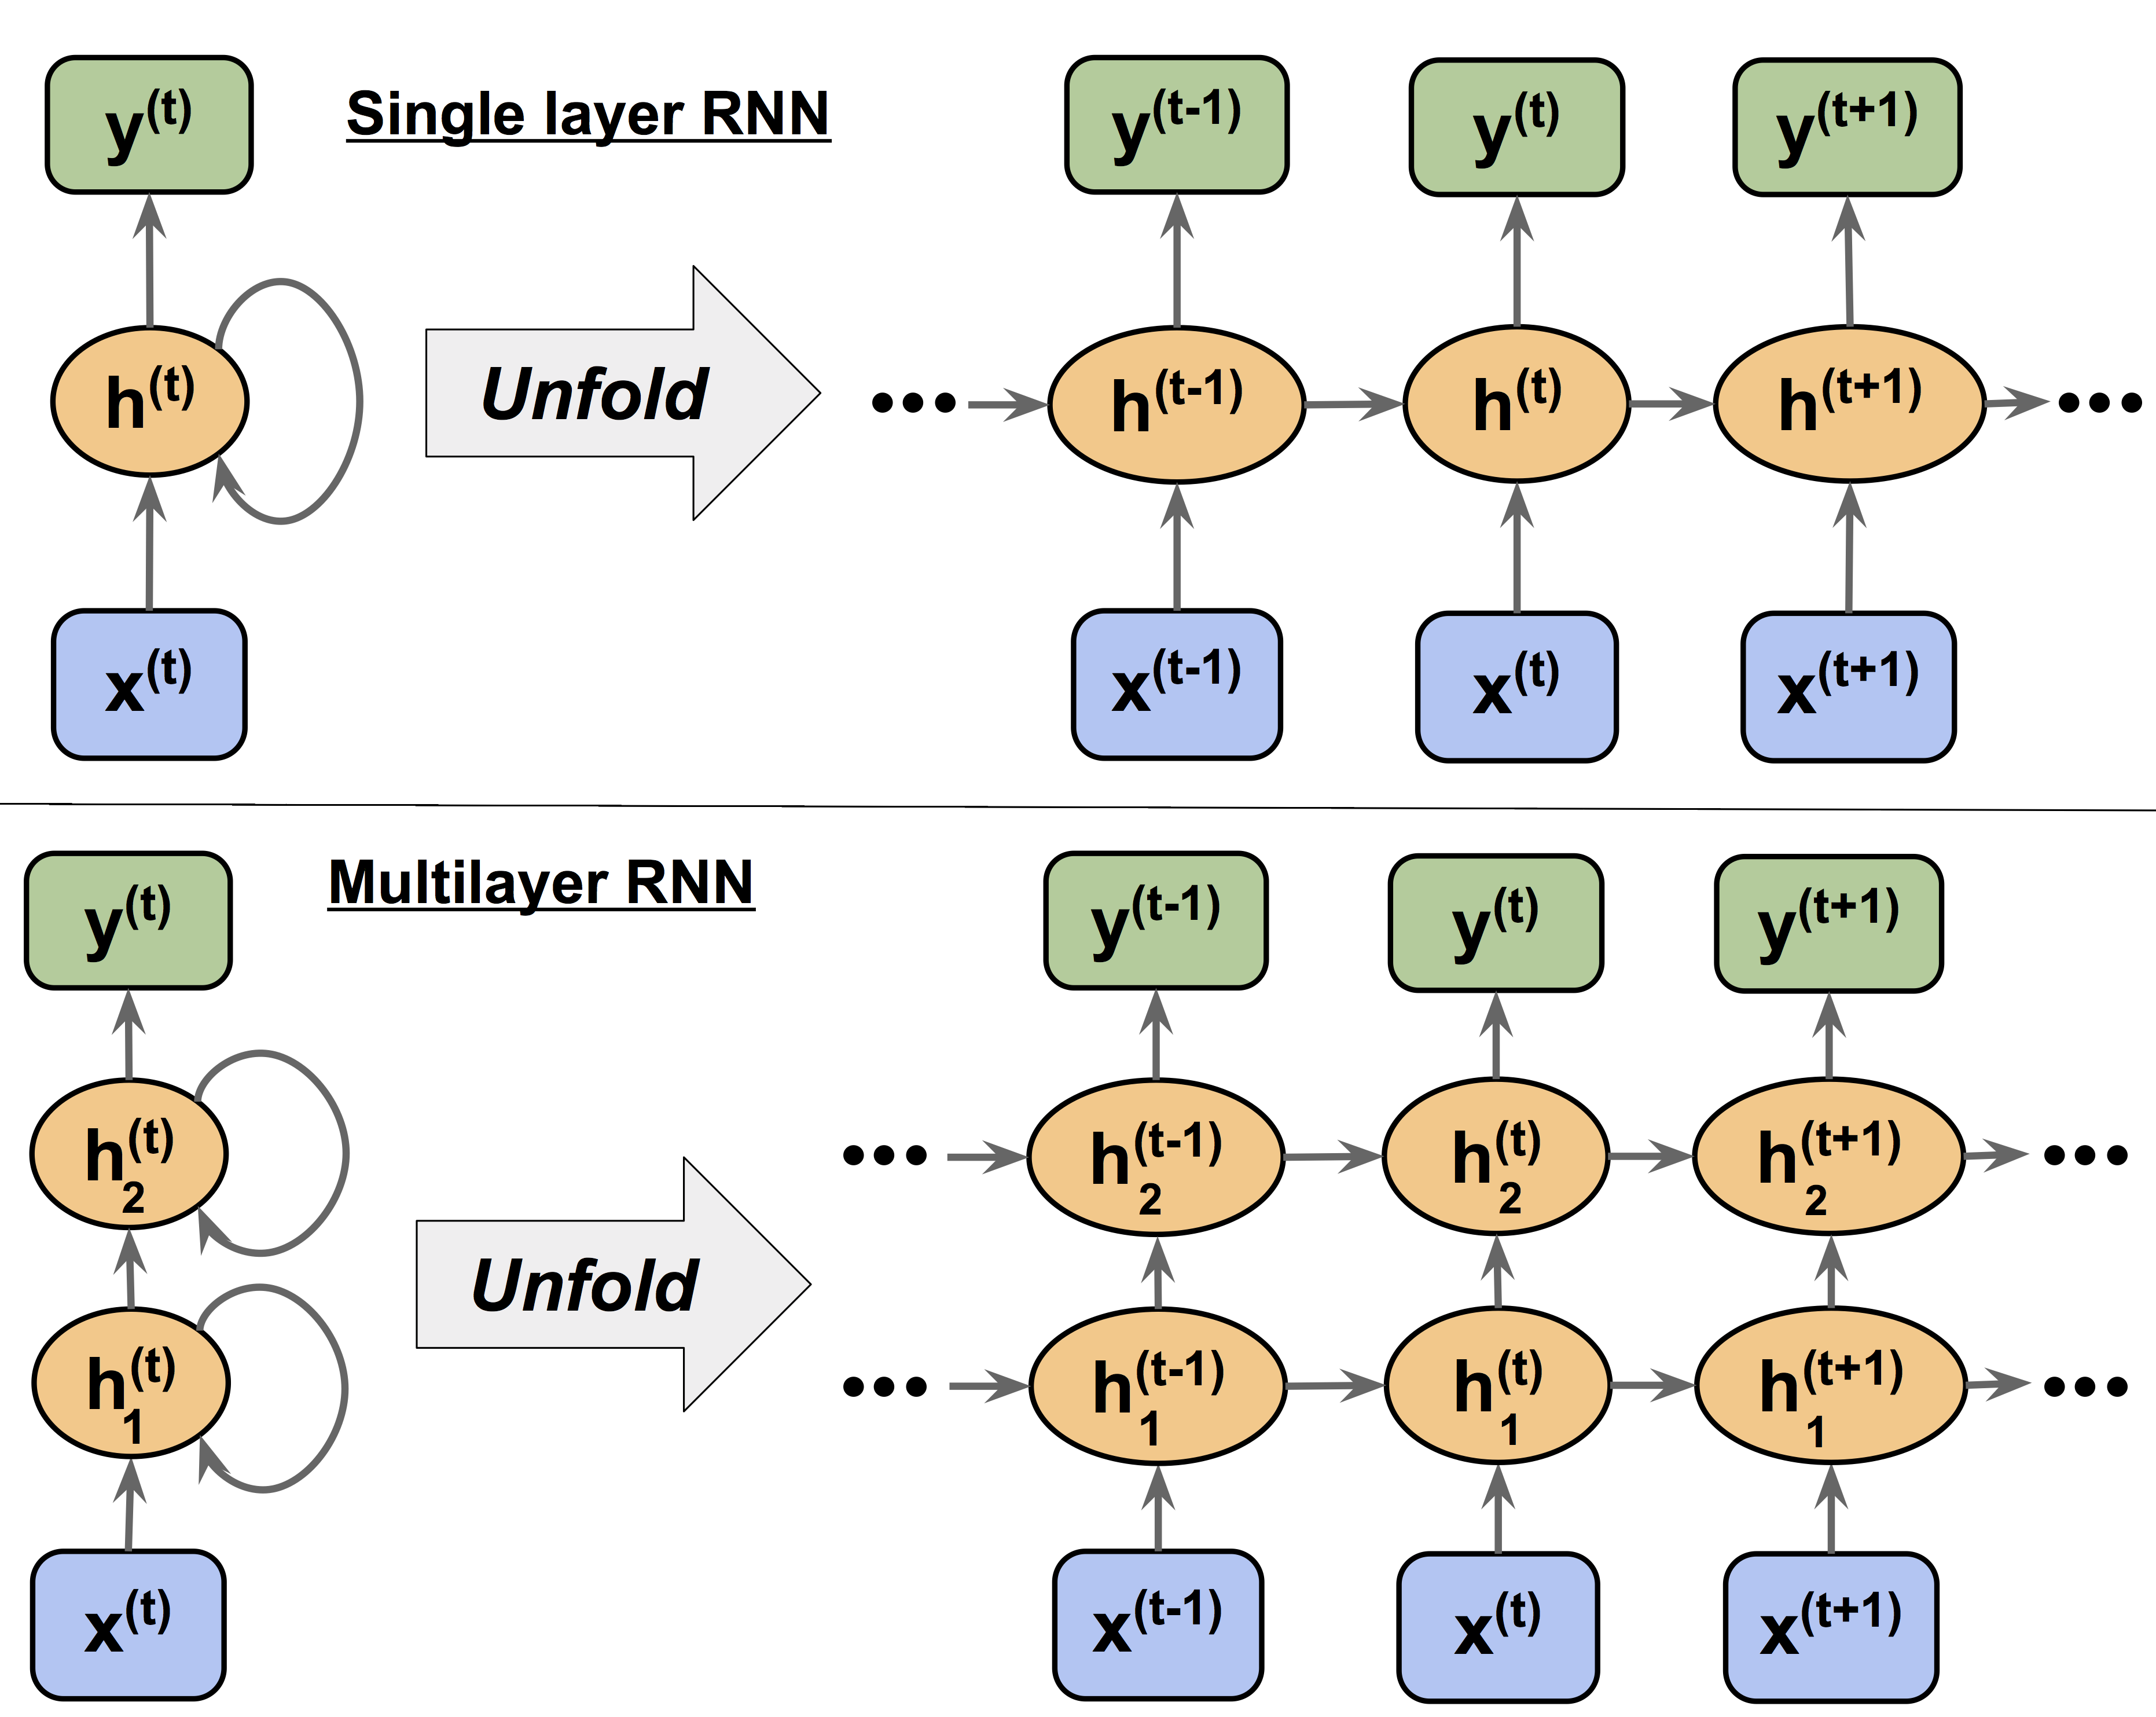

In [16]:
Image(filename='images/Unknown-8.png', width=600)

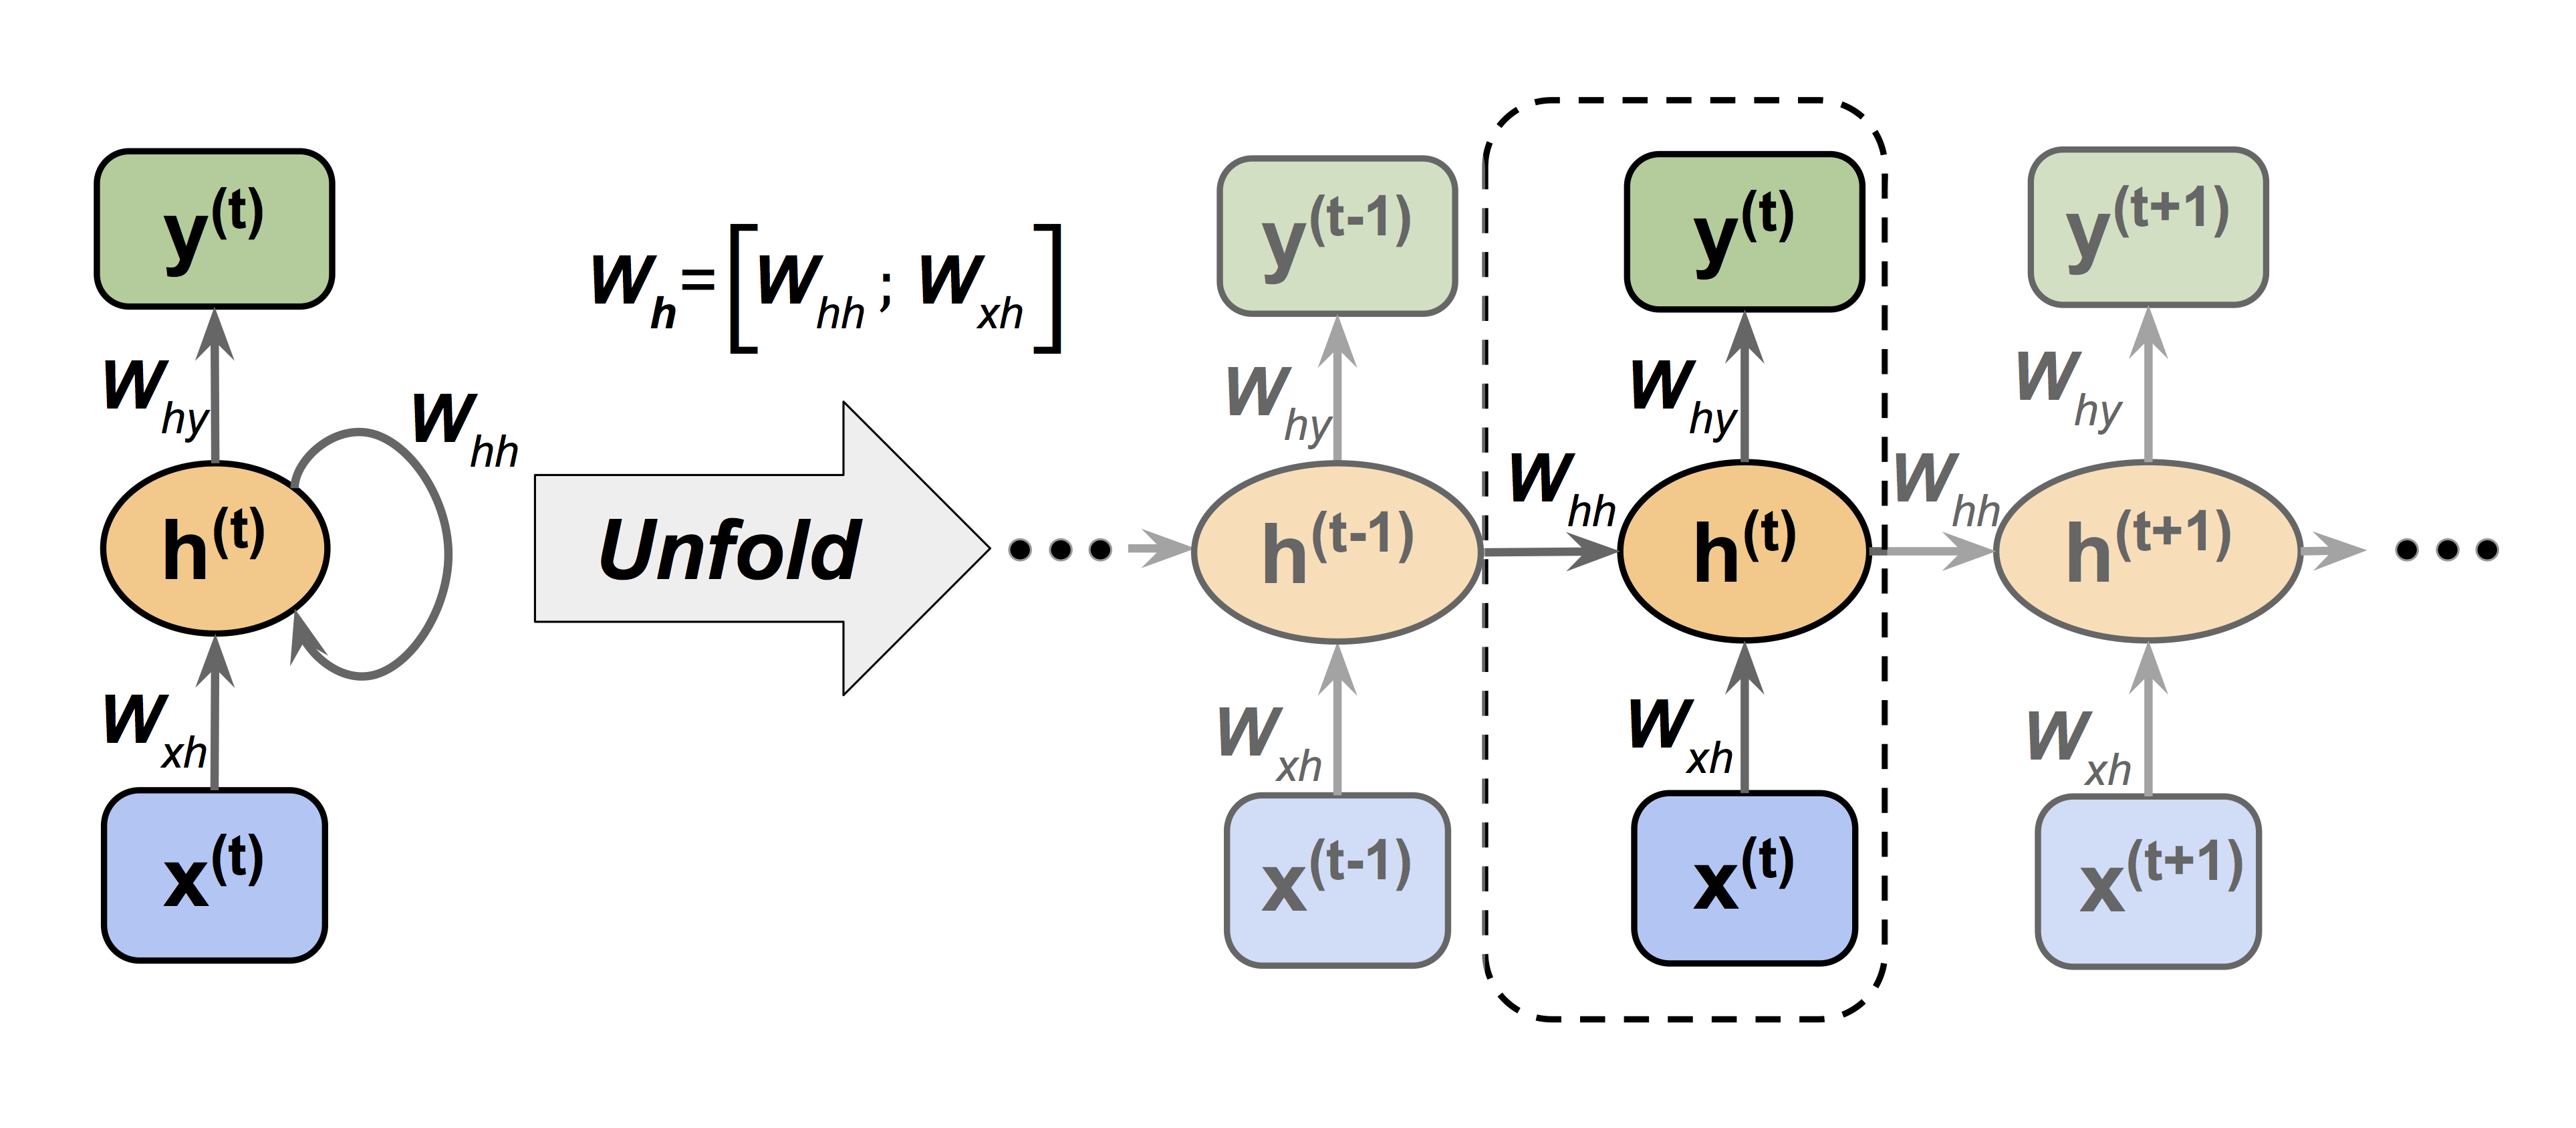

In [17]:
# Computing activations in an RNN
Image(filename='images/Unknown-9.png', width=600)

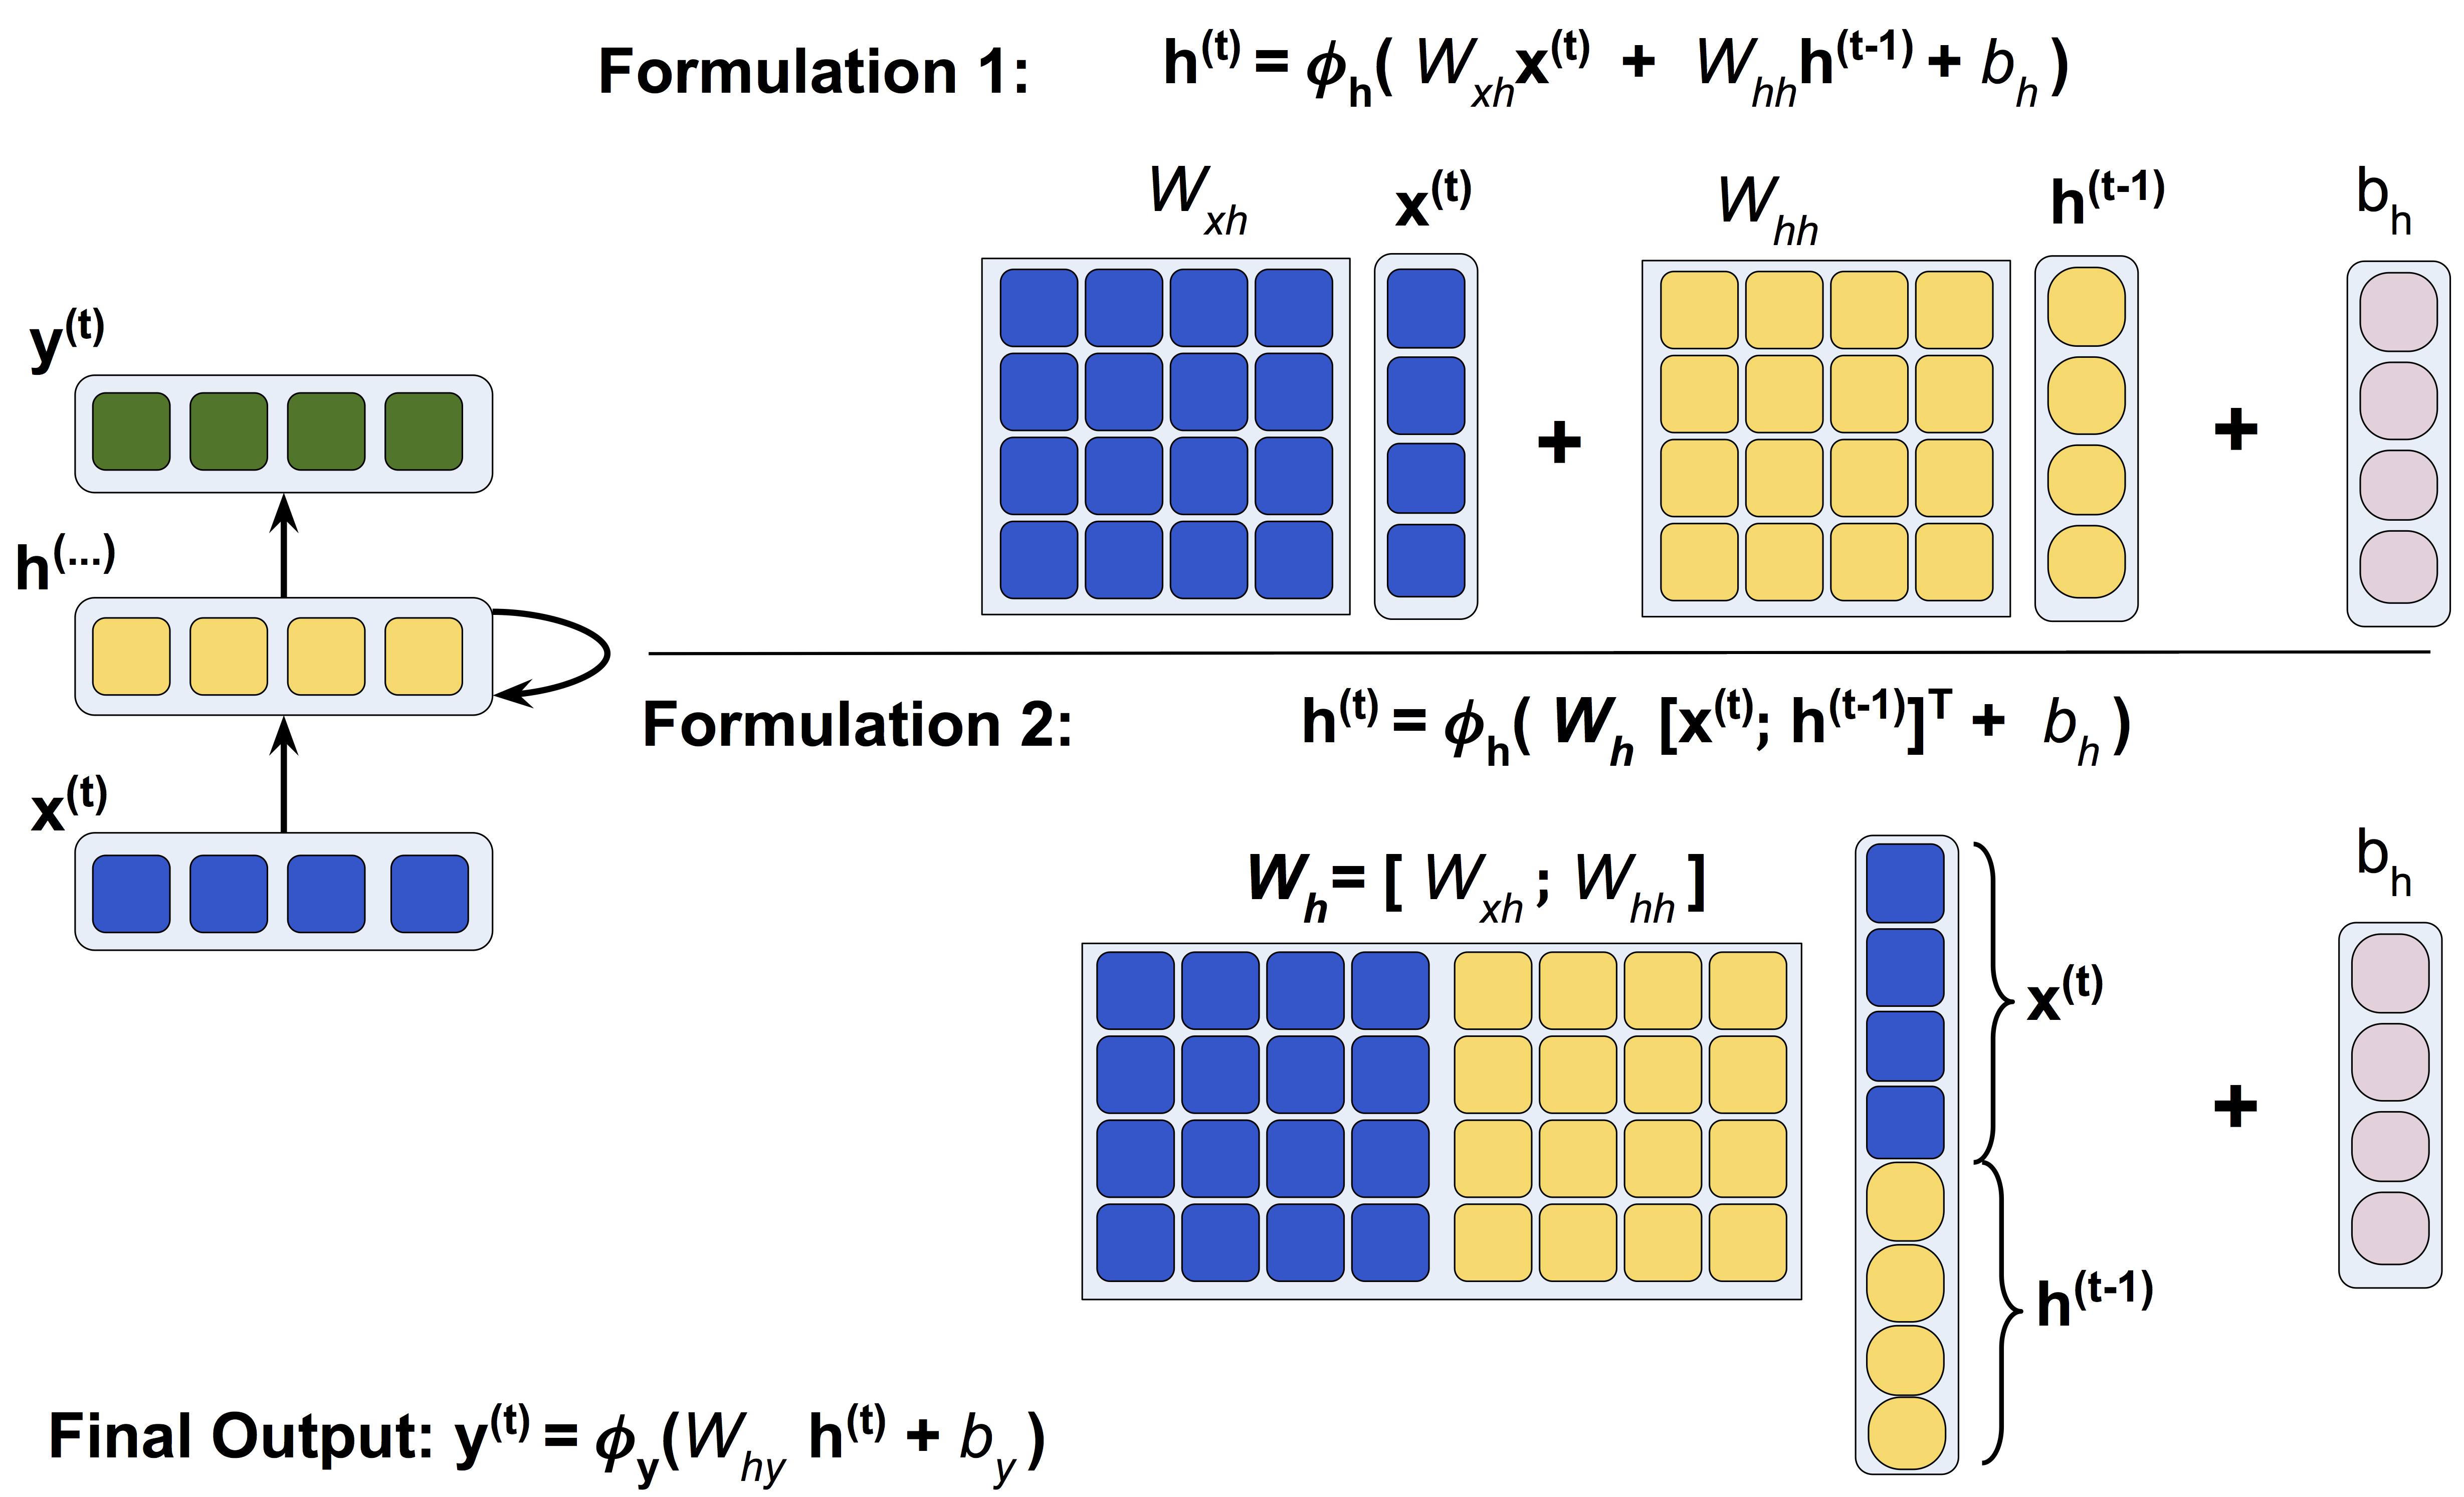

In [18]:
Image(filename='images/Unknown-10.png', width=600)

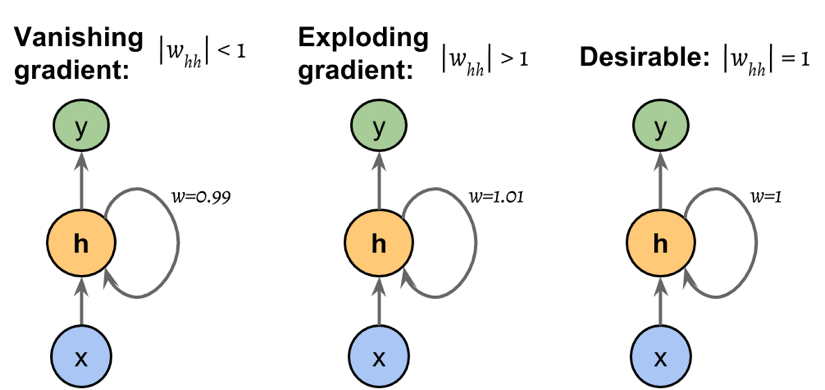

In [19]:
# The challenges of learning long-range interactions
Image(filename='images/Unknown-11.png', width=600)

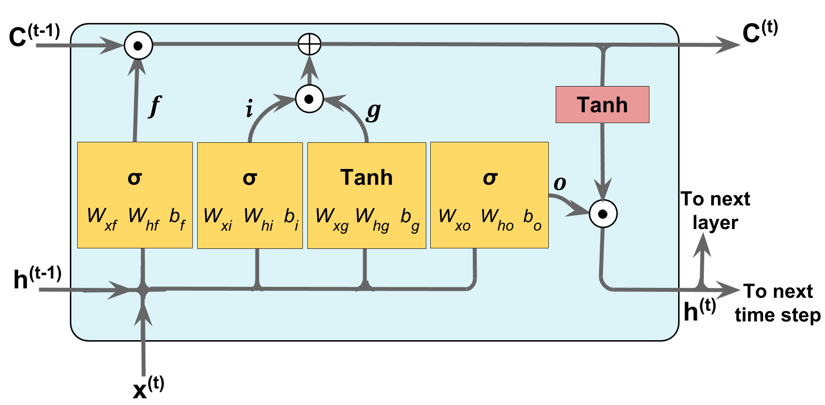

In [20]:
# Long short-term memory(LSTM) units

Image(filename='images/Unknown-12.png', width=600)

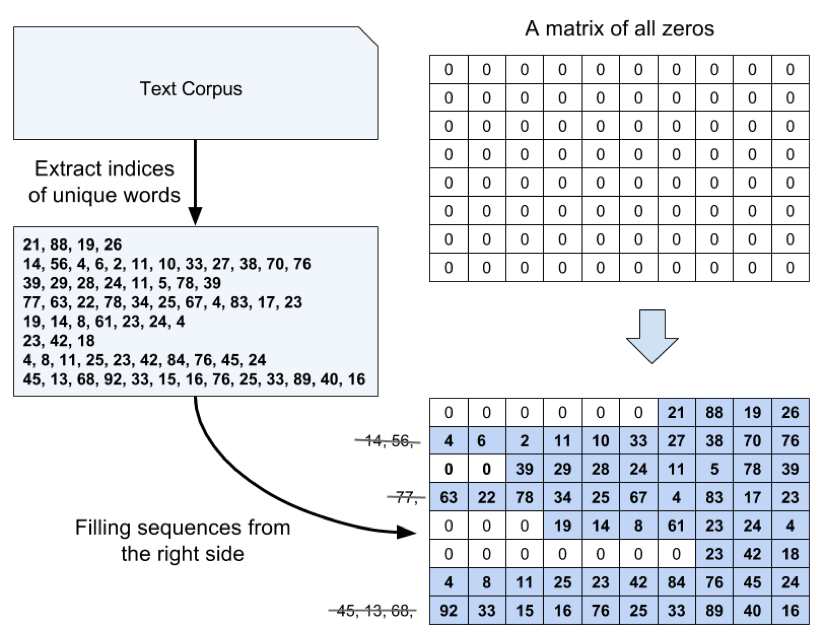

In [21]:
#Implementing a multilayer RNN for sequence modeling in TensorFlow
#Performing sentiment analysis of IMDb movie reviews using multilayer RNNs
#Preparing the data

Image(filename='images/Unknown-13.png', width=600)

In [1]:
import pyprind
import pandas as pd
from string import punctuation
import re
import numpy as np


df = pd.read_csv('movie_data.csv', encoding='utf-8')
print(df.head(3))

                                              review  sentiment
0  In 1974, the teenager Martha Moxley (Maggie Gr...          1
1  OK... so... I really like Kris Kristofferson a...          0
2  ***SPOILER*** Do not read this, if you think a...          0


To prepare the data for input to a neural network, we need to encode it into numeric values.To do this, we first need the unique words in the entire dataset.

We create a mapping in the form of a dictionary that maps each unique word, in our dataset, to a unique integer number.

In [2]:
## Preprocessing the data:
## Separate words and 
## count each word's occurrence


from collections import Counter


counts = Counter()
pbar = pyprind.ProgBar(len(df['review']),
                       title='Counting words occurences')
for i,review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' ' \
                    for c in review]).lower()
    df.loc[i,'review'] = text
    pbar.update()
    counts.update(text.split())

Counting words occurences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:51


In [3]:
## Create a mapping:
## Map each unique word to an integer

word_counts = sorted(counts, key=counts.get, reverse=True)
print(word_counts[:5])
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}


mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']),
                       title='Map reviews to ints')
for review in df['review']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])
    pbar.update()

Map reviews to ints


['the', '.', ',', 'and', 'a']


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


So far, we've converted sequence of words into sequence of integers. But sequences currently have different length. In order to generate input data that is compatible with our RNN architecture, we will need to make sure that all the sequences have the same length.

After we preprocess the dataset, we can proceed with splitting the data into separete training and test sets.

Finally, we define one helper function that breaks a given dataset into chunks and returns a generator to iterate through these chunks(mini-batches).

This is very useful techniques for handling memory limitations. This is the recommended approach for splitting the dataset into mini-batches for training a neural network, rather than creating all the data splits upfront and keeping them in memory during training.

In [6]:
## Define fixed-length sequences:
## Use the last 200 elements of each sequence
## if sequence length < 200: left-pad with zeros

sequence_length = 200  ## sequence length (or T in our formulas)
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)
for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]

X_train = sequences[:25000, :]
y_train = df.loc[:25000, 'sentiment'].values
X_test = sequences[25000:, :]
y_test = df.loc[25000:, 'sentiment'].values


np.random.seed(123) # for reproducibility

## Function to generate minibatches:
def create_batch_generator(x, y=None, batch_size=64):
    n_batches = len(x)//batch_size
    x= x[:n_batches*batch_size]
    if y is not None:
        y = y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        if y is not None:
            yield x[ii:ii+batch_size], y[ii:ii+batch_size]
        else:
            yield x[ii:ii+batch_size]

# Building the RNN Model

In [7]:
import tensorflow as tf


class SentimentRNN(object):
    def __init__(self, n_words, seq_len=200,
                 lstm_size=256, num_layers=1, batch_size=64,
                 learning_rate=0.0001, embed_size=200):
        self.n_words = n_words
        self.seq_len = seq_len
        self.lstm_size = lstm_size   ## number of hidden units
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.embed_size = embed_size

        self.g = tf.Graph()
        with self.g.as_default():
            tf.set_random_seed(123)
            self.build()
            self.saver = tf.train.Saver()
            self.init_op = tf.global_variables_initializer()

    def build(self):
        ## Define the placeholders
        tf_x = tf.placeholder(tf.int32,
                    shape=(self.batch_size, self.seq_len),
                    name='tf_x')
        tf_y = tf.placeholder(tf.float32,
                    shape=(self.batch_size),
                    name='tf_y')
        tf_keepprob = tf.placeholder(tf.float32,
                    name='tf_keepprob')
        ## Create the embedding layer
        embedding = tf.Variable(
                    tf.random_uniform(
                        (self.n_words, self.embed_size),
                        minval=-1, maxval=1),
                    name='embedding')
        embed_x = tf.nn.embedding_lookup(
                    embedding, tf_x, 
                    name='embeded_x')

        ## Define LSTM cell and stack them together
        cells = tf.contrib.rnn.MultiRNNCell(
                [tf.contrib.rnn.DropoutWrapper(
                   tf.contrib.rnn.BasicLSTMCell(self.lstm_size),
                   output_keep_prob=tf_keepprob)
                 for i in range(self.num_layers)])

        ## Define the initial state:
        self.initial_state = cells.zero_state(
                 self.batch_size, tf.float32)
        print('  << initial state >> ', self.initial_state)

        lstm_outputs, self.final_state = tf.nn.dynamic_rnn(
                 cells, embed_x,
                 initial_state=self.initial_state)
        ## Note: lstm_outputs shape: 
        ##  [batch_size, max_time, cells.output_size]
        print('\n  << lstm_output   >> ', lstm_outputs)
        print('\n  << final state   >> ', self.final_state)

        ## Apply a FC layer after on top of RNN output:
        logits = tf.layers.dense(
                 inputs=lstm_outputs[:, -1],
                 units=1, activation=None,
                 name='logits')
        
        logits = tf.squeeze(logits, name='logits_squeezed')
        print ('\n  << logits        >> ', logits)
        
        y_proba = tf.nn.sigmoid(logits, name='probabilities')
        predictions = {
            'probabilities': y_proba,
            'labels' : tf.cast(tf.round(y_proba), tf.int32,
                 name='labels')
        }
        print('\n  << predictions   >> ', predictions)

        ## Define the cost function
        cost = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(
                 labels=tf_y, logits=logits),
                 name='cost')
        
        ## Define the optimizer
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train_op = optimizer.minimize(cost, name='train_op')

    def train(self, X_train, y_train, num_epochs):
        with tf.Session(graph=self.g) as sess:
            sess.run(self.init_op)
            iteration = 1
            for epoch in range(num_epochs):
                state = sess.run(self.initial_state)
                
                for batch_x, batch_y in create_batch_generator(
                            X_train, y_train, self.batch_size):
                    feed = {'tf_x:0': batch_x,
                            'tf_y:0': batch_y,
                            'tf_keepprob:0': 0.5,
                            self.initial_state : state}
                    loss, _, state = sess.run(
                            ['cost:0', 'train_op', 
                             self.final_state],
                            feed_dict=feed)

                    if iteration % 20 == 0:
                        print("Epoch: %d/%d Iteration: %d "
                              "| Train loss: %.5f" % (
                               epoch + 1, num_epochs,
                               iteration, loss))

                    iteration +=1
                if (epoch+1)%10 == 0:
                    self.saver.save(sess,
                        "model/sentiment-%d.ckpt" % epoch)

    def predict(self, X_data, return_proba=False):
        preds = []
        with tf.Session(graph = self.g) as sess:
            self.saver.restore(
                sess, tf.train.latest_checkpoint('model/'))
            test_state = sess.run(self.initial_state)
            for ii, batch_x in enumerate(
                create_batch_generator(
                    X_data, None, batch_size=self.batch_size), 1):
                feed = {'tf_x:0' : batch_x,
                        'tf_keepprob:0': 1.0,
                        self.initial_state : test_state}
                if return_proba:
                    pred, test_state = sess.run(
                        ['probabilities:0', self.final_state],
                        feed_dict=feed)
                else:
                    pred, test_state = sess.run(
                        ['labels:0', self.final_state],
                        feed_dict=feed)
                    
                preds.append(pred)
                
        return np.concatenate(preds)

# Step 1: Defining multilayer RNN cells
# Step 2: Defining the initial states for the RNN cells
# Step 3: Creating the recurrent neural network using the RNN cells and their states

In [8]:
## Train:

n_words = max(list(word_to_int.values())) + 1

rnn = SentimentRNN(n_words=n_words, 
                   seq_len=sequence_length,
                   embed_size=256, 
                   lstm_size=128, 
                   num_layers=1, 
                   batch_size=100, 
                   learning_rate=0.001)

  << initial state >>  (LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(100, 128) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(100, 128) dtype=float32>),)

  << lstm_output   >>  Tensor("rnn/transpose:0", shape=(100, 200, 128), dtype=float32)

  << final state   >>  (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(100, 128) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(100, 128) dtype=float32>),)

  << logits        >>  Tensor("logits_squeezed:0", shape=(100,), dtype=float32)

  << predictions   >>  {'probabilities': <tf.Tensor 'probabilities:0' shape=(100,) dtype=float32>, 'labels': <tf.Tensor 'labels:0' shape=(100,) dtype=int32>}


In [9]:
rnn.train(X_train, y_train, num_epochs=40)

Epoch: 1/40 Iteration: 20 | Train loss: 0.70637
Epoch: 1/40 Iteration: 40 | Train loss: 0.60539
Epoch: 1/40 Iteration: 60 | Train loss: 0.66977
Epoch: 1/40 Iteration: 80 | Train loss: 0.51997
Epoch: 1/40 Iteration: 100 | Train loss: 0.53567
Epoch: 1/40 Iteration: 120 | Train loss: 0.59073
Epoch: 1/40 Iteration: 140 | Train loss: 0.45970
Epoch: 1/40 Iteration: 160 | Train loss: 0.43817
Epoch: 1/40 Iteration: 180 | Train loss: 0.45852
Epoch: 1/40 Iteration: 200 | Train loss: 0.45753
Epoch: 1/40 Iteration: 220 | Train loss: 0.42869
Epoch: 1/40 Iteration: 240 | Train loss: 0.48586
Epoch: 2/40 Iteration: 260 | Train loss: 0.39664
Epoch: 2/40 Iteration: 280 | Train loss: 0.30718
Epoch: 2/40 Iteration: 300 | Train loss: 0.31172
Epoch: 2/40 Iteration: 320 | Train loss: 0.33450
Epoch: 2/40 Iteration: 340 | Train loss: 0.30583
Epoch: 2/40 Iteration: 360 | Train loss: 0.25545
Epoch: 2/40 Iteration: 380 | Train loss: 0.41464
Epoch: 2/40 Iteration: 400 | Train loss: 0.35470
Epoch: 2/40 Iteration: 4

Epoch: 14/40 Iteration: 3300 | Train loss: 0.03658
Epoch: 14/40 Iteration: 3320 | Train loss: 0.00325
Epoch: 14/40 Iteration: 3340 | Train loss: 0.02659
Epoch: 14/40 Iteration: 3360 | Train loss: 0.00215
Epoch: 14/40 Iteration: 3380 | Train loss: 0.03560
Epoch: 14/40 Iteration: 3400 | Train loss: 0.01132
Epoch: 14/40 Iteration: 3420 | Train loss: 0.00520
Epoch: 14/40 Iteration: 3440 | Train loss: 0.11881
Epoch: 14/40 Iteration: 3460 | Train loss: 0.02035
Epoch: 14/40 Iteration: 3480 | Train loss: 0.00424
Epoch: 14/40 Iteration: 3500 | Train loss: 0.00247
Epoch: 15/40 Iteration: 3520 | Train loss: 0.00154
Epoch: 15/40 Iteration: 3540 | Train loss: 0.00591
Epoch: 15/40 Iteration: 3560 | Train loss: 0.00991
Epoch: 15/40 Iteration: 3580 | Train loss: 0.00187
Epoch: 15/40 Iteration: 3600 | Train loss: 0.00148
Epoch: 15/40 Iteration: 3620 | Train loss: 0.06541
Epoch: 15/40 Iteration: 3640 | Train loss: 0.00201
Epoch: 15/40 Iteration: 3660 | Train loss: 0.00137
Epoch: 15/40 Iteration: 3680 | 

Epoch: 27/40 Iteration: 6520 | Train loss: 0.01468
Epoch: 27/40 Iteration: 6540 | Train loss: 0.00284
Epoch: 27/40 Iteration: 6560 | Train loss: 0.00949
Epoch: 27/40 Iteration: 6580 | Train loss: 0.00122
Epoch: 27/40 Iteration: 6600 | Train loss: 0.00600
Epoch: 27/40 Iteration: 6620 | Train loss: 0.00272
Epoch: 27/40 Iteration: 6640 | Train loss: 0.00119
Epoch: 27/40 Iteration: 6660 | Train loss: 0.00820
Epoch: 27/40 Iteration: 6680 | Train loss: 0.02572
Epoch: 27/40 Iteration: 6700 | Train loss: 0.00088
Epoch: 27/40 Iteration: 6720 | Train loss: 0.00447
Epoch: 27/40 Iteration: 6740 | Train loss: 0.00314
Epoch: 28/40 Iteration: 6760 | Train loss: 0.00042
Epoch: 28/40 Iteration: 6780 | Train loss: 0.05133
Epoch: 28/40 Iteration: 6800 | Train loss: 0.00135
Epoch: 28/40 Iteration: 6820 | Train loss: 0.00100
Epoch: 28/40 Iteration: 6840 | Train loss: 0.00062
Epoch: 28/40 Iteration: 6860 | Train loss: 0.00085
Epoch: 28/40 Iteration: 6880 | Train loss: 0.03110
Epoch: 28/40 Iteration: 6900 | 

Epoch: 39/40 Iteration: 9740 | Train loss: 0.00002
Epoch: 40/40 Iteration: 9760 | Train loss: 0.00003
Epoch: 40/40 Iteration: 9780 | Train loss: 0.00005
Epoch: 40/40 Iteration: 9800 | Train loss: 0.00001
Epoch: 40/40 Iteration: 9820 | Train loss: 0.00001
Epoch: 40/40 Iteration: 9840 | Train loss: 0.00034
Epoch: 40/40 Iteration: 9860 | Train loss: 0.00003
Epoch: 40/40 Iteration: 9880 | Train loss: 0.00002
Epoch: 40/40 Iteration: 9900 | Train loss: 0.00008
Epoch: 40/40 Iteration: 9920 | Train loss: 0.00004
Epoch: 40/40 Iteration: 9940 | Train loss: 0.00005
Epoch: 40/40 Iteration: 9960 | Train loss: 0.00000
Epoch: 40/40 Iteration: 9980 | Train loss: 0.00000
Epoch: 40/40 Iteration: 10000 | Train loss: 0.00001


In [10]:
## Test: 
preds = rnn.predict(X_test)
y_true = y_test[:len(preds)]
print('Test Acc.: %.3f' % (
      np.sum(preds == y_true) / len(y_true)))

INFO:tensorflow:Restoring parameters from model/sentiment-39.ckpt
Test Acc.: 0.860


In [11]:
## Get probabilities:
proba = rnn.predict(X_test, return_proba=True)

INFO:tensorflow:Restoring parameters from model/sentiment-39.ckpt
